In [1]:
import time
import numpy as np
from datetime import datetime, timedelta
import shutil
import pickle
import copy
import gc

import pandas as pd
pd.options.display.max_columns=100
pd.options.display.max_rows=100

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import (mean_squared_error, accuracy_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import interpolate

In [3]:
import sys
import os
sys.path.append(f'{os.path.dirname(os.getcwd())}/utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe)

In [139]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2020.csv',
#                  'GBPUSD_1h_2003-2020.csv',
#                  'USDJPY_1h_2003-2020.csv',
#                  'NZDUSD_1h_2003-2020.csv',
#                  'AUDUSD_1h_2003-2020.csv',
#                  'USDCAD_1h_2003-2020.csv',
#                  'USDCHF_1h_2003-2020.csv',
                ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-11-1'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

EURUSD_1h_2003-2020.csv


In [67]:
# loaded_files_a = prep_fx_data(fx_files)
# start = '2000-01-01'
# end = '2020-11-1'
# ## download data
# all_stock_data = download_data_local_check('SP500', start, end)
# loaded_files_b = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)
# loaded_files = {**loaded_files_a, **loaded_files_b}

In [140]:
def ohlc_diff(data):
    prev_close = data['close'].shift(1)
    for col in ['open', 'high', 'low', 'close']:
        data[f'ohlc_diff_{col}'] = (data[col] - prev_close) / prev_close
        data.loc[data.index.values[0], f'ohlc_diff_{col}'] = 0
    data.dropna(inplace=True)
    return data


def add_opposite_bars(loaded_files, var):
    already_done = any(['opposite' in inst for inst in loaded_files.keys()])
    if already_done:
        print('already done opposite bars')
        return
    
    new_data = {}
    for inst, data in loaded_files.items():
        data = data.copy()
        if 'Volume' in data.columns:
            data.drop('Volume', axis='columns', inplace=True)
        data = data[data.index < var.train_split[1]]
        if len(data) < 100:
            continue
        cols = ['open','high','low','close']
        data.columns = cols
        data = ohlc_diff(data)
        data['close_opp'] = ((data['ohlc_diff_close'] * -1) + 1).cumprod() * data['close'][0]
        prev_close = data['close_opp'].shift(1)
        data['open_opp'] = ((data['ohlc_diff_open'] * -1) + 1) * prev_close
        data['low_opp'] = ((data['ohlc_diff_high'] * -1) + 1) * prev_close
        data['high_opp'] = ((data['ohlc_diff_low'] * -1) + 1) * prev_close
        opposite_bars = data[['open_opp','high_opp','low_opp','close_opp']]
        opposite_bars.columns = cols
        opposite_bars.loc[opposite_bars.index.values[0], :] = data[cols].values[0]
        new_data[f'opp-{inst}'] = opposite_bars
    loaded_files.update(new_data)


def add_ma_smooth(data, cols, ma_smooth, ma_smooth_diff=False):
    for col in cols:
        data[f'ma_smooth_{col}'] = data[col].rolling(window=ma_smooth).mean()
        if var.ma_smooth_diff:
            data[f'ma_smooth_{col}'] = data[f'ma_smooth_{col}'].pct_change()
    data.dropna(inplace=True)
    return data


def normalize_bars(data, cols, col_to_norm='ohlc_diff', norm_ma=1000):
    for col in cols:
        mins = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).min()
        maxs = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).max()
        means = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).mean()
        ranges = maxs - mins
        #data[col] = (data[col] - mins) / ranges
        data[f'norm_{col_to_norm}{col}'] = (data[f'{col_to_norm}{col}'] - means) / ranges
        data[f'norm_{col_to_norm}{col}'].replace([np.inf, -np.inf], 0, inplace=True)
    data.dropna(inplace=True)
    return data


def sliding_window_data(data, cols_to_shift, window, timestep):
    # create window data
    for win in range(window):
        for i, col in enumerate(cols_to_shift):
            row_idx = win * len(cols_to_shift) # num_cols
            data[str(row_idx + i)] = data[col].shift(-win)
    return data


def window_labels(data, window, timestep, data_percentage_diff):
    # add time step labels
    label_bar = data['close'].shift(-((window - 1) + timestep))
    if data_percentage_diff == False:
        data['num_bars_label'] = label_bar
    elif data_percentage_diff == 'close_diff':
        last_bar = data['close'].shift(-(window - 1))
        data['num_bars_label'] = (label_bar - last_bar) / last_bar
    return data


def create_sliding_window(data, main_col, var):
    cols_to_shift = [f'{main_col}{col}' for col in var.cols]
    data = sliding_window_data(data, cols_to_shift, var.window, var.num_bars)
    data = window_labels(data, var.window, var.num_bars, var.data_percentage_diff)
    return data


def rolling_bar_volatility(data, ma=100):
    bar_high_low = data['high'] - data['low']
    bar_high_low_pct_diff = bar_high_low / data['high']
    roll_avg_bar_pct_size = (bar_high_low_pct_diff.rolling(window=ma, min_periods=0).mean()
                            .reset_index(drop=True))
    roll_avg_bar_pct_size = np.array(roll_avg_bar_pct_size)
    return roll_avg_bar_pct_size


def triple_barrier(data, window=1, bar_horizon=1000, bar_size_ma=100, target_stop_size=3,
                   target_stop_type='high_low', problem_type='binary', just_labels=False):

    last_bars = data['close'].shift(-(window - 1))
    roll_avg_bar_pct_size = rolling_bar_volatility(data, ma=bar_size_ma)
    child_pct = roll_avg_bar_pct_size * target_stop_size
    child_distance = last_bars * child_pct
    target_series = last_bars + child_distance
    stop_series = last_bars - child_distance

    if target_stop_type == 'high_low':
        highs = data['high'].to_numpy()
        lows = data['low'].to_numpy()
        opens = data['open'].to_numpy()
    elif target_stop_type == 'close':
        highs = lows = data['close'].to_numpy()
        opens = data['open'].to_numpy()
    else:
        raise Exception('target_stop_type not recognised!')
        
    closes = data['close'].to_numpy()
    targets = target_series.to_list()
    stops = stop_series.to_list()

    not_hit_target_or_stop = 0
    hit_target_and_stop = 0
    gap_stop = 0
    gap_target = 0
    labels = []
    for idx in range(len(closes)):
        if idx == (len(closes) - window):
            labels.append([np.nan, closes[-1], 'neither'])
            break

        last_bar = last_bars[idx]
        target = targets[idx]
        stop = stops[idx]
        start_idx = (window - 1) + idx + 1
        future_highs = highs[start_idx: start_idx + bar_horizon]
        future_lows = lows[start_idx: start_idx + bar_horizon]
        future_closes = closes[start_idx: start_idx + bar_horizon]
        future_opens = opens[start_idx: start_idx + bar_horizon]
        
        larger_than_target = future_highs > target
        target_idx = None if larger_than_target.sum() == 0 else larger_than_target.argmax()
        smaller_than_stop = future_lows < stop
        stop_idx = None if smaller_than_stop.sum() == 0 else smaller_than_stop.argmax()

        if target_idx == None and stop_idx == None:
            # manual exit at end of bar horizon
            not_hit_target_or_stop += 1
            fraction_target_stop = (future_closes[-1] - last_bar) / child_distance[idx]
            labels.append([fraction_target_stop, future_closes[-1], 'neither'])
        elif target_idx == None:
            labels.append([-1, stop, 'stop'])
        elif stop_idx == None:
            labels.append([1, target, 'target'])
        elif stop_idx < target_idx:
            if future_opens[stop_idx] < stop:
                gap_stop += 1
                fraction_target_stop = (future_opens[stop_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[stop_idx], 'target'])
            else:
                labels.append([-1, stop, 'stop'])
        elif target_idx < stop_idx:
            if future_opens[target_idx] > target:
                gap_target += 1
                fraction_target_stop = (future_opens[target_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[stop_idx], 'stop'])
            else:
                labels.append([1, target, 'target'])
        elif target_idx == stop_idx:
            hit_target_and_stop += 1
            random_side =  np.random.choice([0,1])
            if random_side == 0:
                labels.append([-1, stop, 'rand_stop'])
            else:
                labels.append([1, target, 'rand_target'])
        else:
            raise Exception('stop or target not recognised, bug!')
       
    print(f'# trades not hit target or stop: {not_hit_target_or_stop}')
    print(f'# trades hit both target and stop: {hit_target_and_stop}')
    print(f'# trades gapped stop: {gap_stop} | # trades gapped target: {gap_target}')
    
    for _ in range(window - 1):
        labels.append([np.nan, closes[-1], 'end of data'])
        
    target_stops = pd.DataFrame(labels, columns=['perc_target_stop',
                                                 'price_target_stop',
                                                 'target_stop_class'])
    target_stops.index = data.index
    data['perc_target_stop'] = target_stops['perc_target_stop']
    if not just_labels:
        data['last_bar'] = last_bars
        data['child_pct'] = child_pct
        data['child_dist'] = child_distance
        data['target_level'] = target_series
        data['stop_level'] = stop_series
        data['price_target_stop'] = target_stops['price_target_stop']
        data['target_stop_class'] = target_stops['target_stop_class']
        
    if problem_type == 'binary':
        data['target'] = (target_stops['perc_target_stop'] >= 0).astype(int) 
        #print('dropping trades that did not meet a target or stop!')
        #data = data[target_stops['target_stop_class'].isin(['stop', 'target'])]
    elif problem_type == 'category':
        data = data[target_stops['target_stop_class'].isin(['stop', 'target', 'neither'])]
        hit_target = target_stops['target_stop_class'] == 'target'
        hit_stop = target_stops['target_stop_class'] == 'stop'
        hit_neither = target_stops['target_stop_class'] == 'neither'
        data.loc[hit_target, 'target'] = 2
        data.loc[hit_stop, 'target'] = 0
        data.loc[hit_neither, 'target'] = 1
    return data


def plot_target_stop(data, var, bars, start_idx, v_line_delta, h_line_price):
    # only plots HOURLY price data currently
    cols = ['open', 'high', 'low', 'close']
    plot_frame = data[cols + ['stop_level', 'target_level', 'perc_target_stop']].copy()
    for col in var.cols:
        plot_frame[f'last_{col}'] = plot_frame[col].shift(-(var.window - 1))
    
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6), gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plot_cols = [f'last_{col}' for col in cols]
    plot_frame[plot_cols + ['stop_level', 'target_level']][start_idx:start_idx+bars].plot(
        ax=ax[0], style=['g','grey','grey','r','k--','k--'])
    v_line_idx = plot_frame[start_idx:start_idx+bars].index[0] + v_line_delta
    ax[0].axvline(v_line_idx, c='k', linewidth=1)
    ax[0].axhline(h_line_price, c='k', linewidth=1)
    
    data['perc_target_stop'][start_idx:start_idx+bars].plot(ax=ax[1])
    ax[1].axvline(v_line_idx, c='k', linewidth=1)
    plt.show()
    return plot_frame[start_idx:start_idx+bars]


def create_dataset(loaded_files, var):
    final_data = []
    for i, (inst, data) in enumerate(loaded_files.items()):
        print(i, inst)
        
        
        if i > var.num_instruments:
            opps = [x for x in loaded_files.keys() if 'opp-' in x][:var.num_instruments]
            if inst not in opps:
                continue
            
        if len(data) < (var.window + 100):
            print(f'{inst} not enough data')
            continue
            
        data = data.copy()
        if 'Volume' in list(data.columns):
            data.drop('Volume', axis=1, inplace=True)
        cols = ['open', 'high', 'low', 'close']
        data.columns = cols
        if var.resample:
            data = data.resample(var.resample).agg({'open':'first','high':'max',
                                                    'low':'min','close':'last'})
            data = data.ffill()
            
        main_col = ''
        data = ohlc_diff(data)
        if var.data_percentage_diff:
            main_col = 'ohlc_diff_'            
        if var.ma_smooth:
            data = add_ma_smooth(data, var.cols, var.ma_smooth)
            main_col = 'ma_smooth'
        if var.standardize:
            data = normalize_bars(data, var.cols, col_to_norm=main_col, norm_ma=var.norm_ma)
            main_col = f'norm_{main_col}'
        data = create_sliding_window(data, main_col, var)
        
        if var.target_stop:
            data = triple_barrier(data, var.window, var.bar_horizon, var.bar_size_ma,
                                  var.target_stop_size, var.target_stop_type,
                                  var.problem_type, just_labels=False)
        data.dropna(inplace=True)
        data['inst'] = inst.split('_')[0]
        final_data.append(data)
        
    if len(final_data) == 0:
        print('no data found!')
        return []
    else:
        data = pd.concat(final_data, axis=0)
        data.sort_index(inplace=True)
        return data

In [141]:
class algo_variables():
    pass

experiment_path = f'B:/Algo_Trading'
var = algo_variables()
var.cols = ['open', 'high', 'low', 'close'] #['close'] #['open', 'high', 'low', 'close']
var.opposite_bars = False
var.upsample_classes = False
var.num_instruments = 30
var.ma_smooth = False #100, False  # create ma of prices
var.ma_smooth_diff = False 
var.data_percentage_diff = 'close_diff' #'close_diff' False
var.window = 300
var.standardize = 'min_max' # 'min_max' False
var.norm_ma = 10000 # running window of min_max of bars to normalize bars
var.train_split = (
    datetime(2016,1,1), # validation
    datetime(2018,1,1), # test
)
var.resample = None # None '1D', '4H', '1W'

var.num_bars = 30 # prediction horizon
var.problem_type = 'category' #'regression' 'binary' 'category'

## target/stop binary outcomes (1 R/R) ##
var.target_stop = True
if var.target_stop:
    var.num_bars = 1
    var.target_stop_type = 'high_low' #'high_low', 'close'
    var.bar_horizon = 20 # how long to wait for stop or target hit, otherwise assign current profit
    var.bar_size_ma = 100 # how long is moving average for bar size (used to calc stop and target)
    var.target_stop_size = 2 # size of stop and target relative to averge bar size
    
var.embeddings = False
# var.embedding_type = None #None 'light'
# if var.embeddings:
#     var.standardize = False 
#     var.pca_features = False
#     var.vector_size = 200 # 200, 4
#     if var.embedding_type == 'light':
#         var.vector_size = 1

##
var.input_len = var.window * len(var.cols)
##

generator = False
train_dataset, test_dataset = [], []
# if generator: 
#     ## save all stocks to csv and tfrecords, then load tfrecords as dataset
#     var.train_validation = 0.8 #False # Uses traning data to create test set (for validation)
#     var.batch_size = 500
#     base_path = f'C:/Users/Jameshuckle/Documents/Algo_Trading/data'
#     save_numpy_to_csv_all_files(base_path, var)
#     train_dataset = create_tfrecord_dataset(f'{base_path}/all_data_train', var)
#     test_dataset = create_tfrecord_dataset(f'{base_path}/all_data_test', var)
# else:
#     ### load single stock into numpy
#     (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
#      test_data_raw) = create_dataset(file_name=list(loaded_files.keys())[0], var=var)
#     train_dataset, test_dataset = [], []

if var.opposite_bars:
    add_opposite_bars(loaded_files, var)
###############################   
data = create_dataset(loaded_files, var)

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 15358
# trades hit both target and stop: 619
# trades gapped stop: 37 | # trades gapped target: 31


In [70]:
# single_inst = data[data['inst'] == 'FITB'].copy()
# plot_target_stop(single_inst, var, bars=00, start_idx=2500,
#                  v_line_delta=timedelta(days=6, hours=0, minutes=0), h_line_price=30)

In [71]:
# data_path = f'{os.path.dirname(os.getcwd())}/data'
# data.to_csv(f'{data_path}/fx_dnn_data_1D_binary_300win_3tar.csv')

In [142]:
def upsample_data(input_data, splits, label):
    print('\n--- upsampling minority classes ---\n')
    for split in splits:
        class_counts = input_data[split][label].value_counts()
        largest_class = class_counts.values.max()
        class_ratios = class_counts.to_dict()
        for cls, n_rows in class_ratios.items():
            diff_from_max = largest_class - n_rows
            class_data = input_data[split][input_data[split][label] == cls]
            samples = class_data.sample(diff_from_max)
            data = pd.concat([input_data[split], samples], axis=0)  
            data.sort_index(inplace=True)
            if split == 'test': 
                input_data['upsample_test'] = data
            else:
                input_data[split] = data
    return input_data

        
def target_stop_ratio(input_data, splits, label='target', problem_type='binary'):
    class_percs = {}
    for split in splits:
        class_ratios = input_data[split][label].value_counts().to_dict()
        print(class_ratios)
        idx = 1 if problem_type == 'binary' else 2
        t_s_perc = input_data[split][label].value_counts(normalize=True).to_dict()
        print(f'percentage that hit target at base ({split}): {t_s_perc[idx]:.3f}')
        class_percs[split] = t_s_perc
    return class_percs


def training_split(data, train_split_list, features, label):
    # data must have datetime index

    # train/valid/test split
    input_data = {}
    input_data['train'] = data[data.index < train_split_list[0]]
    input_data['test'] = data[data.index >= train_split_list[-1]]
    if len(train_split_list) == 2:
        input_data['valid'] = data[((data.index >= train_split_list[0]) & 
                                    (data.index < train_split_list[1]))]
        
    for split, split_data in input_data.items():
        print(split, len(split_data))
        if len(split_data) == 0:
            raise Exception(f'no data in {split}')
        
    splits = ['train', 'test']
    if len(train_split_list) == 2:
        splits = ['train','valid','test']
    class_percs = target_stop_ratio(input_data, splits, label=label, problem_type=var.problem_type)
    if var.upsample_classes:
        input_data = upsample_data(input_data, splits, label)
        class_percs = target_stop_ratio(input_data, splits, label=label,
                                     problem_type=var.problem_type)
    
    input_data['x_train'] = input_data['train'][features].to_numpy()
    input_data['y_train'] = input_data['train'][label].to_numpy().reshape(-1, 1)
    input_data['x_test'] = input_data['test'][features].to_numpy()
    input_data['y_test'] = input_data['test'][label].to_numpy().reshape(-1, 1)
    if var.upsample_classes:
        input_data['x_upsample_test'] = input_data['upsample_test'][features].to_numpy()
        input_data['y_upsample_test'] = (input_data['upsample_test'][label].to_numpy()
                                         .reshape(-1, 1))
    if len(train_split_list) == 2:
        input_data['x_valid'] = input_data['valid'][features].to_numpy()
        input_data['y_valid'] = input_data['valid'][label].to_numpy().reshape(-1, 1)
    return input_data, class_percs


label = 'num_bars_label' if var.target_stop == False else 'target'
features = [str(c) for c in list(range(var.window * len(var.cols)))]
input_data, class_percs = training_split(data, var.train_split, features, label)
    
# data = all_data    
# label = 'target'
# not_features = ['open', 'high', 'low', 'close', 'daily_return', 'target']
# features = [c for c in list(data.columns) if c not in not_features]
# input_data = training_split(data, var.train_split, features, label)

train 77254
test 17211
valid 12397
{2.0: 33489, 0.0: 32622, 1.0: 11143}
percentage that hit target at base (train): 0.433
{2.0: 5576, 0.0: 5022, 1.0: 1799}
percentage that hit target at base (valid): 0.450
{0.0: 7501, 2.0: 7294, 1.0: 2416}
percentage that hit target at base (test): 0.424


In [143]:
class MonteCarloDropout(layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

def dnn_model_sweep(l1_reg, l2_reg, drop_rate, activation, input_len,
                    output_layer, layer_kwargs, var):
    #input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    first = layers.Input(shape=(input_len,))
    hidden_layers = []
    for i in range(var.layers):
        hidden_layers.append(layers.Dense(units=var.units, activation=activation,
                                          kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs))
        if i < (var.layers - 1):
            if activation == 'selu':
                hidden_layers.append(layers.AlphaDropout(drop_rate))
            else:
                if var.batchnorm == True:
                    hidden_layers.append(layers.BatchNormalization())
                    hidden_layers.append(MonteCarloDropout(drop_rate))
                else:
                    hidden_layers.append(layers.Dropout(drop_rate))
    model = tf.keras.Sequential([first] + hidden_layers + [output_layer])
    return model


def lstm_model_sweep(l1_reg, l2_reg, drop_rate, activation, input_len,
                     output_layer, layer_kwargs, var):
    input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    inputs = layers.Reshape((input_len, input_vector_size))
    first_return = False
    lstm_layers = []
    for _ in range(var.lstm_layers - 1):
        lstm_layers.append(layers.LSTM(units=var.units, return_sequences=first_return,
                                       kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs)) 
        first_return = True
              
    first = layers.LSTM(units=var.units, return_sequences=first_return,
                        input_shape=[None, input_vector_size],
                        **layer_kwargs) 
    hidden_layers = []
    for i in range(var.layers):
        hidden_layers.append(layers.Dense(units=var.units, activation=activation,
                                          kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs)) 
        if i < (var.layers - 1):
            hidden_layers.append(layers.Dropout(drop_rate))
            #hidden_layers.append(layers.AlphaDropout(drop_rate))
    model = tf.keras.Sequential([inputs] + [first] + lstm_layers[::-1] + hidden_layers + [output_layer])
    return model


def skip_connection(l1_reg, l2_reg, drop_rate, activation, input_len,
                    output_layer, layer_kwargs, var):
    var.units = input_len
    inputs = tf.keras.Input(shape=(var.input_len,))
    x1 = inputs
    for i in range(var.layers):
        l1 = layers.Dense(units=input_len, activation=activation,
                          kernel_regularizer=l1_l2(l1_reg, l2_reg))(x1)
        if i < (var.layers - 1):
            if activation == 'selu':
                d1 = layers.AlphaDropout(drop_rate)(l1)
            else:
                if var.batchnorm:
                    b1 = layers.BatchNormalization()(l1)
                    d1 = layers.Dropout(drop_rate)(b1)
                else:
                    d1 = layers.Dropout(drop_rate)(l1)
            x1 = layers.add([d1, x1])
        else:
            x1 = layers.add([l1, x1])
    outputs = layers.Dense(units=1, activation='sigmoid')(x1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_model_arch(model_arch, var):
    seed_value = 1
    layer_kwargs = {
#         'kernel_initializer':initializers.glorot_uniform(seed=seed_value),
#         'bias_initializer':initializers.Constant(0.1),
    }

    if var.problem_type == 'binary': 
        output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid', **layer_kwargs)
    elif var.problem_type == 'category': 
        output_layer = tf.keras.layers.Dense(units=3, activation='softmax', **layer_kwargs)
    else: 
        output_layer = tf.keras.layers.Dense(units=1, activation=None, **layer_kwargs)

    if model_arch in ['dnn', 'conv1d', 'incept1d', 'lstm']:
        if model_arch == 'dnn': 
            arch = dnn_model_sweep
        elif model_arch == 'conv1d': 
            arch = conv1d_model
        elif model_arch == 'incept1d': 
            arch = inception1d_model
        elif model_arch == 'lstm': 
            arch = lstm_model_sweep

        model = arch(var.l1_reg, var.l2_reg, var.drop_rate, var.activation,
                     var.input_len, output_layer, layer_kwargs, var)

    elif model_arch == 'skip_connection':
        model = skip_connection(var.l1_reg, var.l2_reg, var.drop_rate, var.activation,
                                var.input_len, output_layer, layer_kwargs, var)
    return model


def compile_model(model, lr, var):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    #opt = tf.keras.optimizers.RMSprop(learning_rate=lr)

    if var.problem_type == 'binary': 
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    elif var.problem_type == 'category':
        model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        rmse = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
        model.compile(optimizer=opt, loss='mse', metrics=[rmse])
        
    return model


def set_model_hyperparams(epochs, kwargs, plot_lr_rate, decrease_lr_rate, validation,
                          test_dataset, generator):
        
    if plot_lr_rate:
        kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch / (epochs / 7))))

    elif decrease_lr_rate:
        kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 / 10**(epoch / epochs))) #1e-2
        #kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3))

    if validation:   
        if generator:
            kwargs['validation_data'] = test_dataset
        else:
            None
            #kwargs['validation_split'] = 0.7
            
    return kwargs

In [144]:
def reset_model_checkpoint(path=os.getcwd()):
    total_epochs = 0
    all_history = {}
    # delete last saved model
    checkpoint_path_base = f'{path}/model_checkpoints'
    checkpoint_path_model = checkpoint_path_base + '/model.ckpt'
    if os.path.exists(checkpoint_path_base):
        shutil.rmtree(checkpoint_path_base)
    return total_epochs, all_history, checkpoint_path_base, checkpoint_path_model


def del_unneeded_checkpoints(checkpoint_path_base, all_history, metric):
    print('deleting uneeded checkpoints')
    epochs_idx = [
        np.argmin(all_history['val_loss']) + 1,
        np.argmax(all_history['val_loss']) + 1,
        np.argmin(all_history[f'val_{metric}']) + 1, 
        np.argmax(all_history[f'val_{metric}']) + 1,
        len(all_history['val_loss']),
    ]
    for cp_file in os.listdir(checkpoint_path_base):
        if 'model_epoch-' in cp_file:
            epoch = int(cp_file.split('-')[1].split('.')[0])
            if epoch not in epochs_idx:
                os.remove(f'{checkpoint_path_base}/{cp_file}')
  

def load_and_save_experiments(experiment_path):
    pickle_var_path = f'{experiment_path}/pickled_vars'
    experiment_list = []
    for f in os.listdir(pickle_var_path):
        experiment = pickle.load(open(f'{pickle_var_path}/{f}', 'rb'))
        experiment_list.append(experiment)
    experiments = pd.DataFrame(experiment_list)
    experiments['created_time'] = pd.to_datetime(experiments['created_time'],
                                                 format='%d-%m-%y_%H-%M-%S')
    experiments.sort_values('created_time', inplace=True)
    save_path = f'{os.getcwd()}/results/experiments.csv'
    experiments.transpose().to_csv(save_path)
    print(f'saved experiments at: {save_path}')
    return experiments


def search_experiments(experiment_path, var):
    experiments = load_and_save_experiments(experiment_path)
    match_scores = []
    for row in experiments.to_dict('records'):
        match = 0
        for field, value in row.items():
            if field in vars(var):
                if getattr(var, field) == value:
                    match += 1
        num_fields = len(vars(var).keys())
        match_scores.append(match / num_fields)
    experiments['match_scores'] = pd.Series(match_scores)
    experiments.sort_values('match_scores', ascending=False, inplace=True)
    summary = experiments[[
        'match_scores',
        'created_time',
        'best_loss',
        'best_accuracy',
        'best_val_loss',
        'best_val_accuracy',
        'best_test_loss',
        'best_test_accuracy',
        'epochs',
        'experiment_model_path',
    ]]
    summary.set_index('created_time')
    return experiments.transpose(), summary.transpose()

In [145]:
tf.keras.backend.clear_session()
###
var.model_arch = 'dnn' # 'dnn','lstm','conv1d','incept1d', 'skip_connection'
var.activation = 'relu'
var.batchnorm = False
var.l1_reg = 1e-5 #1e-9 #1e-6
var.l2_reg = 1e-4 #1e-8 #1e-5
var.drop_rate = 0 #0.1 #0.2
###
var.layers = 5
var.units = 100
var.lstm_layers = 1

if var.model_arch == 'lstm':
    var.input_len = var.window

model = get_model_arch(var.model_arch, var)

(total_epochs, all_history, checkpoint_path_base,
 checkpoint_path_model) = reset_model_checkpoint(
    path='B:/Algo_Trading/model_checkpoints')

In [76]:
# experiments, summary = search_experiments(experiment_path, var)
# print(summary.loc['experiment_model_path'].iloc[0])
# summary
#experiments
#experiments.transpose().sort_values('best_val_accuracy', ascending=False)

In [151]:
# load model to keep continuity of epochs. To create new model run cell above.
if os.path.exists(checkpoint_path_model):
    print('loading model')
    model = tf.keras.models.load_model(checkpoint_path_model)

var.lr = 1e-4
model = compile_model(model=model, lr=var.lr, var=var)

gc.collect()

plot_lr_rate = False # set to 100 epochs
decrease_lr_rate = False
validation = True
var.epochs = 150

checkpoint_path_cb = checkpoint_path_base+'/model_epoch-{epoch}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_cb,
                                                 save_best_only=False,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max', verbose=0)

kwargs = {'verbose':2, 'epochs':var.epochs, 'initial_epoch':total_epochs, 'shuffle':False,
          'callbacks':[cp_callback]}
kwargs = set_model_hyperparams(var.epochs, kwargs, plot_lr_rate, decrease_lr_rate,
                               validation, test_dataset, generator)

# Balance class weights 
max_cls = max(class_percs['train'].values())
var.class_weights = {}
for cls, ratio in class_percs['train'].items():
    var.class_weights[cls] = max_cls / class_percs['train'][cls]
kwargs['class_weight'] = var.class_weights
print(var.class_weights)

if generator:
    ### Parellelize loading
    history = model.fit(x=train_dataset, **kwargs)
else:
    var.batch_size = 32
    history = model.fit(input_data['x_train'], input_data['y_train'],
                        validation_data=(input_data['x_valid'], input_data['y_valid']),
                        batch_size=var.batch_size, **kwargs)
                        
model.save(checkpoint_path_model)
print('\n---------------')
total_epochs = var.epochs
print('\ntotal_epochs',total_epochs)
gc.collect()

for key, value in history.history.items():
    all_history.setdefault(key, [])
    all_history[key] += value

loading model
{2.0: 1.0, 0.0: 1.0265771565201398, 1.0: 3.0053845463519697}
Epoch 51/150
2415/2415 - 7s - loss: 0.7201 - accuracy: 0.5757 - val_loss: 2.0214 - val_accuracy: 0.3578
Epoch 52/150
2415/2415 - 7s - loss: 0.7219 - accuracy: 0.5756 - val_loss: 2.0551 - val_accuracy: 0.3613
Epoch 53/150
2415/2415 - 7s - loss: 0.7231 - accuracy: 0.5762 - val_loss: 2.0539 - val_accuracy: 0.3622
Epoch 54/150
2415/2415 - 7s - loss: 0.7187 - accuracy: 0.5774 - val_loss: 2.1414 - val_accuracy: 0.3569
Epoch 55/150
2415/2415 - 7s - loss: 0.7169 - accuracy: 0.5777 - val_loss: 2.2382 - val_accuracy: 0.3519
Epoch 56/150
2415/2415 - 7s - loss: 0.7202 - accuracy: 0.5768 - val_loss: 2.2006 - val_accuracy: 0.3457
Epoch 57/150
2415/2415 - 7s - loss: 0.7153 - accuracy: 0.5810 - val_loss: 2.9467 - val_accuracy: 0.3121
Epoch 58/150
2415/2415 - 7s - loss: 0.7162 - accuracy: 0.5812 - val_loss: 2.4215 - val_accuracy: 0.3475
Epoch 59/150
2415/2415 - 7s - loss: 0.7147 - accuracy: 0.5804 - val_loss: 2.2122 - val_accura

Epoch 129/150
2415/2415 - 8s - loss: 0.3881 - accuracy: 0.8823 - val_loss: 4.8767 - val_accuracy: 0.3794
Epoch 130/150
2415/2415 - 8s - loss: 0.3796 - accuracy: 0.8849 - val_loss: 4.8427 - val_accuracy: 0.3877
Epoch 131/150
2415/2415 - 7s - loss: 0.3876 - accuracy: 0.8824 - val_loss: 4.9111 - val_accuracy: 0.3869
Epoch 132/150
2415/2415 - 7s - loss: 0.3756 - accuracy: 0.8882 - val_loss: 4.9949 - val_accuracy: 0.3853
Epoch 133/150
2415/2415 - 7s - loss: 0.3695 - accuracy: 0.8908 - val_loss: 4.8939 - val_accuracy: 0.3907
Epoch 134/150
2415/2415 - 7s - loss: 0.3733 - accuracy: 0.8893 - val_loss: 5.0107 - val_accuracy: 0.3866
Epoch 135/150
2415/2415 - 7s - loss: 0.3920 - accuracy: 0.8827 - val_loss: 4.9833 - val_accuracy: 0.3842
Epoch 136/150
2415/2415 - 8s - loss: 0.3811 - accuracy: 0.8875 - val_loss: 4.7461 - val_accuracy: 0.3928
Epoch 137/150
2415/2415 - 8s - loss: 0.3722 - accuracy: 0.8911 - val_loss: 4.7603 - val_accuracy: 0.3955
Epoch 138/150
2415/2415 - 7s - loss: 0.3553 - accuracy:

In [152]:
def plot_learning_rate(all_history, start_epoch=0, end_epoch=-1):
    if plot_lr_rate:
        plt.plot(all_history['lr'][start_epoch:end_epoch],
                 all_history['loss'][start_epoch:end_epoch])
        plt.xscale('log')
        lowest_loss_idx = np.argmin(all_history['loss'])
        print('best lr:',all_history['lr'][lowest_loss_idx])
    elif decrease_lr_rate:
        plt.plot(all_history['lr'][start_epoch:end_epoch],
                 all_history['loss'][start_epoch:end_epoch])
        plt.title('learning rate')
        plt.xscale('log')
        plt.xlim(max(all_history['lr'][start_epoch:end_epoch]),
                 min(all_history['lr'][start_epoch:end_epoch]))
    else:
        plt.plot(all_history['loss'][start_epoch:end_epoch])
        plt.yscale('log')

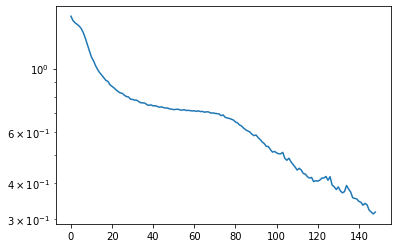

In [153]:
plot_learning_rate(all_history, start_epoch=0, end_epoch=-1)

In [154]:
def plot_learning_curves(metric, validation, epoch_show_from=0):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
    # metric
    ax[0][0].plot(all_history[metric][epoch_show_from:])
    ax[0][0].legend([f'training {metric}'])
    ax[0][0].set_title(metric)
    # loss
    ax[0][1].plot(all_history['loss'][epoch_show_from:])
    ax[0][1].legend([f'training loss'])
    ax[0][1].set_title('loss')

    if validation:
        # metric
        ax[1][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
        ax[1][0].legend([f'validation {metric}'])
        ax[2][0].plot(all_history[metric][epoch_show_from:])
        ax[2][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
        ax[2][0].legend([f'training {metric}',f'validation {metric}'])

        # loss
        ax[1][1].plot(all_history[f'val_loss'][epoch_show_from:])
        ax[1][1].legend([f'validation loss'])
        ax[2][1].plot(all_history['loss'][epoch_show_from:])
        ax[2][1].plot(all_history[f'val_loss'][epoch_show_from:])
        ax[2][1].legend([f'training loss',f'validation loss'])
    else:
        ax[2][0].legend(['train'])
        ax[2][1].legend(['train'])

    training_curves = plt.gca()
    return training_curves

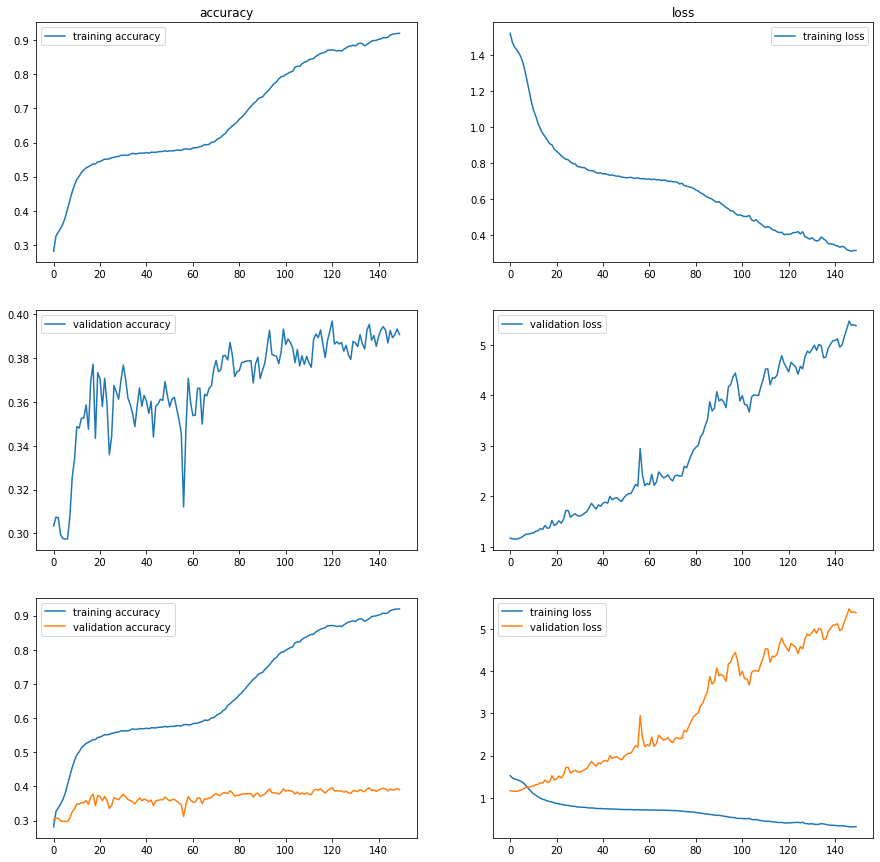

In [155]:
metric = 'root_mean_squared_error' if var.problem_type == 'regression' else 'accuracy'

epoch_show_from = 0
training_curves = plot_learning_curves(metric, validation, epoch_show_from=0)

In [156]:
#del_unneeded_checkpoints(checkpoint_path_base, all_history, metric)

In [157]:
def explore_epoch(metric, man_epoch_idx, man_val_metric, checkpoint_path_base, all_history, model,
                 load_model=True):
    val_metric = f'val_{metric}' if not man_val_metric else man_val_metric
    if man_epoch_idx:
        print('load weights from epoch', man_epoch_idx)
        checkpoint_path = f'{checkpoint_path_base}/model_epoch-{man_epoch_idx}.ckpt'
        best_idx = man_epoch_idx - 1
    else:
        if val_metric in ['val_root_mean_squared_error', 'val_loss', 'loss']:
            best_idx = np.argmin(all_history[val_metric])
        else:
            best_idx = np.argmax(all_history[val_metric])
            
    best_acc = round((all_history[val_metric][best_idx]), 4)
    print(f'best {val_metric}: {best_acc} | epoch={best_idx + 1}')
    checkpoint_path = f'{checkpoint_path_base}/model_epoch-{best_idx + 1}.ckpt'
    
    if load_model:
        print(f'Loaded weights')
        model.load_weights(checkpoint_path)
    return model, checkpoint_path, best_acc, best_idx + 1

In [158]:
man_epoch_idx = 150 #Set to 0 or False to choose best accuracy, otherwise choose epoch to load
man_val_metric = False #False 'val_loss' 'loss', 'accuracy'

(model, checkpoint_path,
 best_acc, best_idx) = explore_epoch(metric, man_epoch_idx, man_val_metric, checkpoint_path_base,
                                     all_history, model, load_model=True)

load weights from epoch 150
best val_accuracy: 0.3908 | epoch=150
Loaded weights


In [159]:
review_set = 'valid'
eval_raw = model.evaluate(input_data[f'x_{review_set}'],
                          input_data[f'y_{review_set}'], verbose=0)
eval_result = dict(zip(['loss', metric], np.round(eval_raw ,3)))
print(eval_result)

{'loss': 5.38, 'accuracy': 0.391}


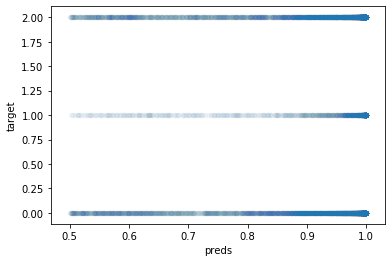

here
{'loss': 6.034, 'accuracy': 0.394}
fees proportion of target: 0.0466
-----
test
Accuracy (manual calc): 0.394
Sharpe: -5.21


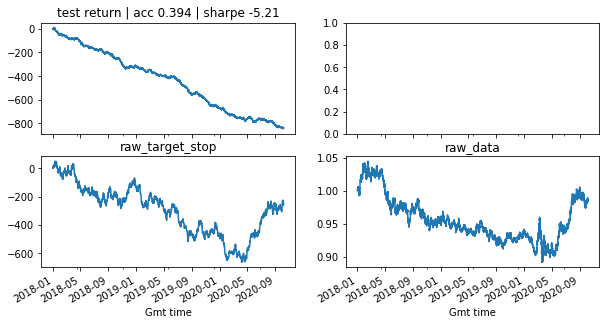

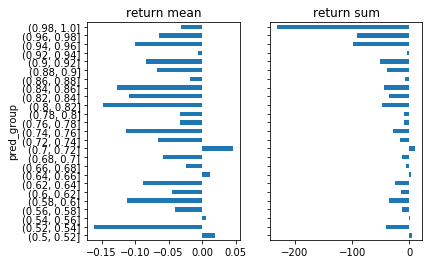

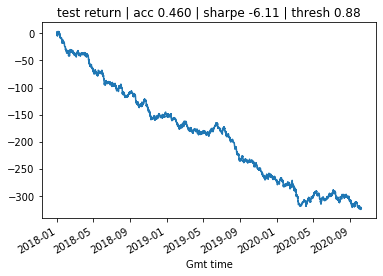

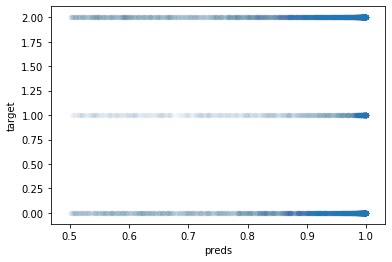

here
{'loss': 5.38, 'accuracy': 0.391}
fees proportion of target: 0.0388
-----
valid
Accuracy (manual calc): 0.391
Sharpe: -3.66


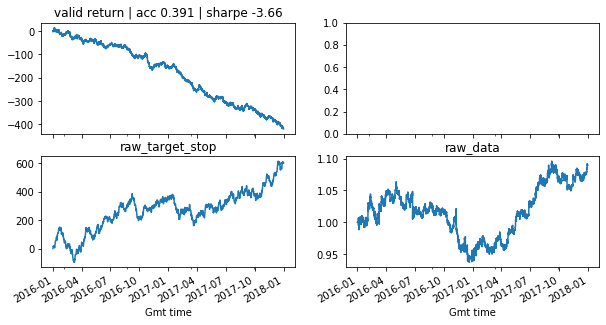

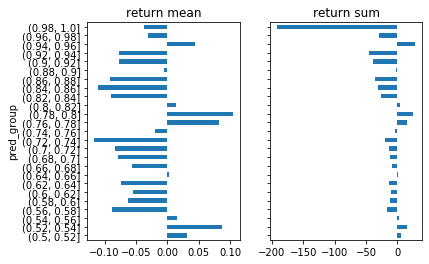

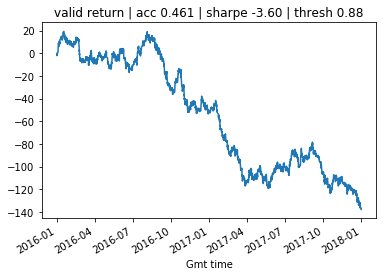

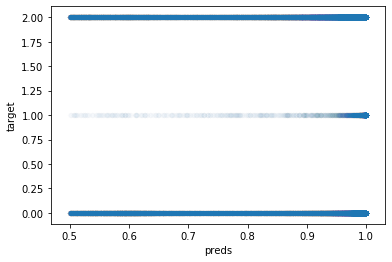

here
{'loss': 0.515, 'accuracy': 0.851}
fees proportion of target: 0.0321
-----
train
Accuracy (manual calc): 0.851
Sharpe: 70.79


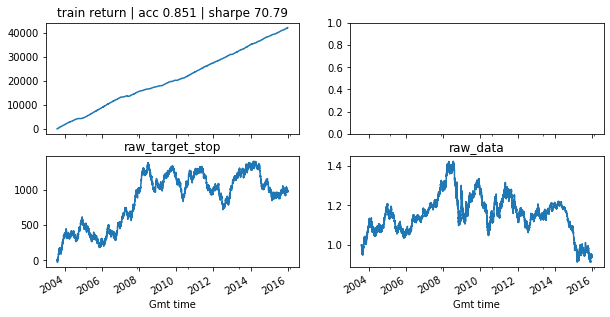

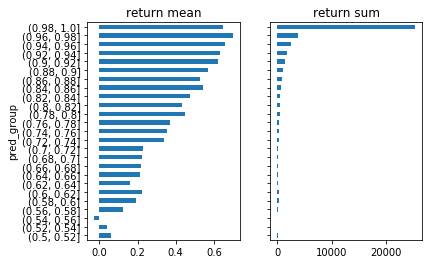

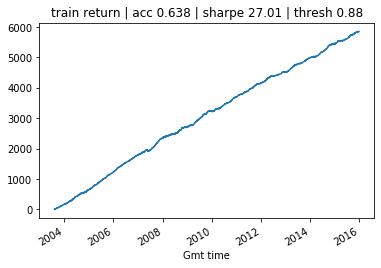

In [160]:
def evaluate_model(model, input_data, metric, review_set, label='target', plot_preds=True):
    # get loss and accuracy for review set
    eval_raw = model.evaluate(input_data[f'x_{review_set}'],
                              input_data[f'y_{review_set}'], verbose=0)
    eval_result = dict(zip(['loss', metric], np.round(eval_raw ,3)))    
    pred = model.predict(input_data[f'x_{review_set}'])
    if var.problem_type == 'binary':
        preds = pd.Series(pred.flatten())
        pred_cols = ['preds']
    elif var.problem_type == 'category':
        category_preds = pd.Series(pred.argmax(axis=1))
        category_preds.index = input_data[review_set].index
        input_data[review_set]['category_preds'] = category_preds
        preds = pd.Series(pred[range(len(pred)), pred.argmax(axis=1)])
        pred_cols = ['preds', 'category_preds']
    preds.index = input_data[review_set].index
    input_data[review_set]['preds'] = preds
    test_results = input_data[review_set][[label] + pred_cols].copy()
    test_results['perc_target_stop'] = input_data[review_set]['perc_target_stop']

    if plot_preds:
        # plot scatter of preds vs label
        test_results.plot.scatter(x='preds', y=label, alpha=0.01); plt.show()
    print('here')
    return eval_result, test_results


def calc_sharpe(returns, time_frame='1D', scale_returns=0.001):
    resample = False
    if time_frame in [None, False]:
        correction = np.sqrt(24*365)
    elif time_frame == '4H':
        correction = np.sqrt(6*365)        
    elif time_frame == '1D':
        correction = np.sqrt(365)
    elif time_frame == '1W':
        correction = np.sqrt(4)
    else:
        raise Exception(f'time_frame "{time_frame}" is not recognized!')
        
    col = returns.name
    returns = returns * scale_returns
    sharpe = (returns.mean() / returns.std()) * correction
    return sharpe


def calc_returns(test_results, review_set, label='target', close_diff_col='ohlc_diff_close', 
                 time_frame='1H', fees=0.0001):
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
    if var.problem_type == 'binary':
        test_results['binary_pred'] = (test_results['preds'] >= 0.5).astype(int)
        test_results['trade_map'] = test_results['binary_pred'].replace(0, -1)
    elif var.problem_type == 'category':
        test_results['binary_pred'] = test_results['category_preds']
        test_results['trade_map'] = test_results['category_preds'] - 1
    fees_pct = (fees / input_data[review_set]['child_pct']) * np.abs(test_results['perc_target_stop'])
    print(f"fees proportion of target: {(fees / input_data[review_set]['child_pct']).mean():.4f}")
    test_results['return'] = (test_results['perc_target_stop'] * test_results['trade_map']) - fees_pct
    test_results['correct'] = ((test_results[label] == test_results['binary_pred']).astype(int))
    acc = test_results['correct'].mean()
    sharpe = calc_sharpe(test_results['return'], time_frame, scale_returns=0.01)
    print('-----')
    print(review_set)
    print(f"Accuracy (manual calc): {acc:.3f}")
    print(f"Sharpe: {sharpe:.2f}")
    
    # plot charts     
    test_results['return'].cumsum().plot(
        title=f'{review_set} return | acc {acc:.3f} | sharpe {sharpe:.2f}', ax=ax[0,0])
    (input_data[review_set][close_diff_col] + 1).cumprod().plot(title='raw_data', ax=ax[1,1])
    test_results['perc_target_stop'].cumsum().plot(title='raw_target_stop', ax=ax[1,0])
    returns_plot = plt.gca()      
    return returns_plot, test_results, sharpe

          
def threshold_trades(test_results, var, inner_thresh):
    threshold_data = test_results[['preds', 'return']]
    threshold_data['pred_group'] = pd.cut(threshold_data['preds'], bins=25)
    table_data = threshold_data.groupby('pred_group')
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
    table_data.mean()['return'].plot.barh(title='return mean', ax=ax[0])
    table_data.sum()['return'].plot.barh(title='return sum', ax=ax[1])
    plt.show()

    subset = threshold_data[(threshold_data['preds'] < inner_thresh) 
                          & (threshold_data['preds'] > (1 - inner_thresh))]
    acc = (subset['return'] > 0).sum() / len(subset)
    sharpe = calc_sharpe(subset['return'], time_frame=var.resample, scale_returns=0.01)
    subset['return'].cumsum().plot(
        title=f'{review_set} return | acc {acc:.3f} | sharpe {sharpe:.2f} | thresh {inner_thresh}')
    plt.show()
          

var.fees = 0.0001 # 0.0001
for review_set in ['test', 'valid', 'train']: #'upsample_test'
#for review_set in ['test']:
    eval_result, test_results = evaluate_model(model, input_data, metric, review_set, label='target',
                                               plot_preds=True) #label='target'     
    print(eval_result)
    returns_plot, test_results, sharpe = calc_returns(test_results, review_set, label='target',
                                                      close_diff_col='ohlc_diff_close',
                                                      time_frame=var.resample, fees=var.fees)

    threshold_trades(test_results, var, inner_thresh=0.88)

In [161]:
#raise Exception('stop here')

In [184]:
var.drop_rate = 0.5
model_bayes = get_model_arch(var.model_arch, var)
weights = model.get_weights()
model_bayes.set_weights(weights)

review_set = 'valid' #upsample_test, test, train, valid
preds = [model_bayes(input_data[f'x_{review_set}'], training=True).numpy() for _ in range(500)]
if var.problem_type == 'binary':
    preds_df = pd.DataFrame(np.hstack(preds))
elif var.problem_type == 'category':
    preds_df = [p[range(len(p)), p.argmax(axis=1)] for p in preds]
    preds_df = pd.DataFrame(preds_df).transpose()

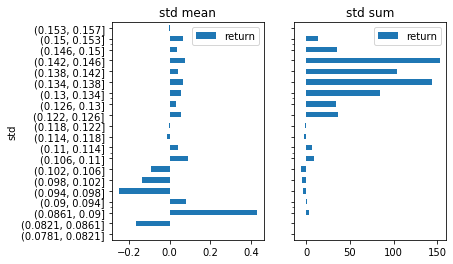

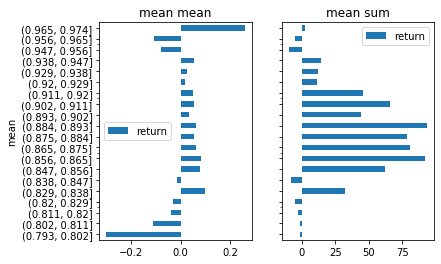

In [185]:
preds_df['mean'] = preds_df.mean(axis=1)
preds_df['std'] = preds_df.std(axis=1)
preds_df['perc'] = input_data[review_set]['perc_target_stop'].values
preds_df['trade_map'] = (preds_df['mean'] >= 0.5).astype(int).replace({0:-1})
preds_df['return'] = preds_df['trade_map'] * preds_df['perc']

for group_col in ['std', 'mean']:
    group_data = preds_df[[group_col, 'return']]
    group_data[group_col] = pd.cut(group_data[group_col], bins=20, precision=0)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
    for i, func in enumerate(['mean', 'sum']):
        getattr(group_data.groupby(group_col), func)().plot.barh(ax=ax[i],
                                                                 title=f'{group_col} {func}')
    plt.show()
    
preds_df.index = input_data[review_set].index

In [186]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def calc_r2_equity(returns):
    '''
    A performance metric (made up by me) that falls between 0-1 generally.
    It is the r2 of the equity curve and a linear fitted line, to the power of 10, 
    which penalizes lower scores more heavily.
    This is a great metric to checking a consistant linearly increasing equity curve;
    however, it penalizes inconsistancy a little too much, so should be used alongside 
    the sharpe ratio, preferably sharpe_ratio * r2_trend to give us an adjusted sharpe
    '''
    idx = np.arange(len(returns))
    curve = returns.cumsum().values

    linreg = LinearRegression()
    linreg.fit(idx.reshape(-1,1), curve)
    idx_lin = linreg.predict(idx.reshape(-1,1))
    slope_int = (linreg.coef_ / abs(linreg.coef_))[0]
    
    r2_equity = r2_score(curve, idx_lin)
    return r2_equity


def calc_dd_time_metric(returns):
    '''
    A performance metric (made up by me) that falls between 0-1.
    We calculate the maxuimum time in a draw down in days and then divide it by 365.
    We then square it to penalize larger drawdowns more.
    '''
    equity = returns.cumsum().copy()
    equity_dd = equity - equity.cummax()
    time_dd = pd.Series((equity_dd[equity_dd == 0].index).append(equity.index[-1:]))
    max_dd_time = min(1, time_dd.diff().max() / timedelta(days=365))
    print('dd_time', time_dd.diff().max())
    dd_time_metric = (1 - max_dd_time) ** 2
    return dd_time_metric
    
    
def calc_sharpe(returns, time_frame='1D', scale_returns=0.001):
    resample = False
    if time_frame in [None, False]:
        correction = np.sqrt(24*365)
    elif time_frame == '4H':
        correction = np.sqrt(6*365)        
    elif time_frame == '1D':
        correction = np.sqrt(365)
    elif time_frame == '1W':
        correction = np.sqrt(4)
    else:
        raise Exception(f'time_frame "{time_frame}" is not recognized!')
        
    col = returns.name
    returns = returns * scale_returns
    sharpe = (returns.mean() / returns.std()) * correction
    return sharpe


def adjusted_sharpe(returns):
    dd_time_metric = calc_dd_time_metric(returns)
    r2_equity = calc_r2_equity(returns)
    print(dd_time_metric, r2_equity)
    return (2 * r2_equity * dd_time_metric) / (r2_equity + dd_time_metric)

# trades: 1607 keep ratio: 0.13
dd_time 140 days 11:00:00


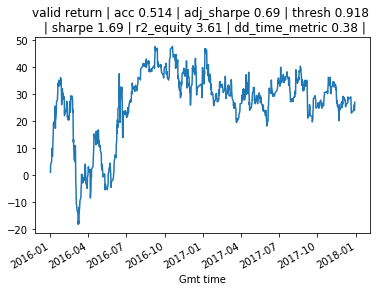

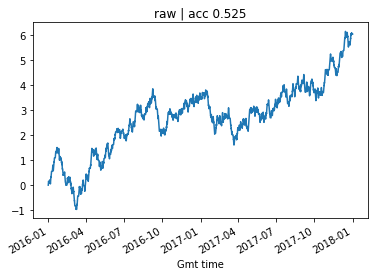

In [187]:
thresh = 0.918
std_thresh = 0.128
threshold_data = preds_df[['return','mean','std']]
subset = threshold_data[
    (
        (threshold_data['mean'] >= thresh) 
#        | (threshold_data['mean'] <= (1 - thresh))
    ) &
    (
        (threshold_data['std'] <= std_thresh) 
    )
]
print(f'# trades: {len(subset)} keep ratio: {len(subset) / len(threshold_data):.2f}')
sharpe = calc_sharpe(subset['return'], time_frame=var.resample, scale_returns=0.01)
r2_equity = calc_r2_equity(subset['return'])
dd_time_metric = calc_dd_time_metric(subset['return'])
final_adj = adjusted_sharpe(subset['return'])
acc = (subset['return'] > 0).sum() / len(subset)
subset['return'].cumsum().plot(
    title=f'{review_set} return | acc {acc:.3f} | adj_sharpe {final_adj:.2f} | thresh {thresh} \n'
        f' | sharpe {sharpe:.2f} | r2_equity {r2_equity:.2f} | dd_time_metric {dd_time_metric:.2f} |')
plt.show()
acc = (input_data[f'{review_set}']['perc_target_stop'] > 0).sum() / len(input_data[f'{review_set}'])
(input_data[f'{review_set}']['perc_target_stop'] * 0.01).cumsum().plot(title=f'raw | acc {acc:.3f}')

In [188]:
def copy_model_and_checkpoint_files(model, metric, checkpoint_path_base,
                                    experiment_model_path, var):
    # save model architecture
    model.save(f'{experiment_model_path}/model.ckpt')
    var.experiment_model_path = experiment_model_path
    
    # get checkpoint for best val_accuracy and val_loss
    for man_val_metric in [False, 'val_loss', 'loss', metric]:
        (model, checkpoint_path,
         best_acc, best_idx) = explore_epoch(metric, man_epoch_idx, man_val_metric,
                                             checkpoint_path_base, all_history, model,
                                             load_model=False)
        # copy saved checkpoint files to experiment directory
        val_metric = f'val_{metric}' if not man_val_metric else man_val_metric
        for f in os.listdir(checkpoint_path_base):
            check_file = checkpoint_path.split('/')[-1]
            if check_file in f:
                shutil.copy(f'{checkpoint_path_base}/{f}', experiment_model_path)
                setattr(var, f'cp_best_{val_metric}', f'{experiment_model_path}/{check_file}')      
                setattr(var, f'best_{val_metric}', best_acc)
                setattr(var, f'epoch_best_{val_metric}', best_idx)
                
                
def save_all_model_info(experiment_path, model, metric, checkpoint_path_base, input_data,
                        loaded_files, all_history, training_curves, label, var):
    time_str = datetime.now().strftime('%d-%m-%y_%H-%M-%S')
    experiment_model_path = f'{experiment_path}/model_checkpoints_experiments/{time_str}'
    copy_model_and_checkpoint_files(model, metric, checkpoint_path_base, experiment_model_path, var) 
       
    for review_set in ['train', 'valid', 'test']:
        eval_result, test_results = evaluate_model(model, input_data, metric, review_set=review_set,
                                                   label=label, plot_preds=False)
        print(eval_result)
        returns_plot, test_results, sharpe = calc_returns(test_results, review_set=review_set,
                                                          label=label, close_diff_col=close_diff_col,
                                                          time_frame=var.resample)
        returns_plot.figure.savefig(f'{experiment_model_path}/return_plot_{review_set}.jpg')
        setattr(var, f'sharpe_{review_set}', sharpe)
    training_curves.figure.savefig(f'{experiment_model_path}/training_curves.jpg')
    
    var.best_test_loss = eval_result['loss']
    setattr(var, f'best_test_{metric}', eval_result[metric])
    var.created_time = time_str
    var.loaded_files = set(loaded_files.keys())
    #var.all_history = all_history

    pickle_path = f"{experiment_path}/pickled_vars/{time_str}.pkl"
    pickle.dump(vars(var), open(pickle_path, 'wb'))
    print('finished saving!')

In [189]:
raise Exception('stop here!')

Exception: stop here!

In [ ]:
var.info = ''

In [ ]:
save_experiment = True #bool


label = 'target' #  'target'
close_diff_col = 'ohlc_diff_close' # 'ohlc_diff_close' , 'daily_return'
if save_experiment:
    save = input('Are you sure you want to save model, y/n?: ')
    if save == 'y':        
        experiment_path = f'B:/Algo_Trading'
        save_all_model_info(experiment_path, model, metric, checkpoint_path_base, input_data,
                            loaded_files, all_history, training_curves, label, var)
        load_and_save_experiments(experiment_path)